# Implémentation TAGI pour classification d'images


In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import struct
import os
from sklearn.metrics import accuracy_score # Changed import for classification
from tqdm import tqdm

# fixe seed
# np.random.seed(0)


# Chargement et prétraitement des données MNIST


In [2]:
def load_mnist_images(filename):
    """Loads MNIST images from an IDX file."""
    with open(filename, 'rb') as f:
        magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
        if magic != 2051:
            raise ValueError(f"Invalid magic number {magic} in image file {filename}")
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows * cols)
    return images

def load_mnist_labels(filename):
    """Loads MNIST labels from an IDX file."""
    with open(filename, 'rb') as f:
        magic, num_items = struct.unpack('>II', f.read(8))
        if magic != 2049:
            raise ValueError(f"Invalid magic number {magic} in label file {filename}")
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

def one_hot_encode(labels, num_classes=10):
    """Converts integer labels to one-hot encoded vectors."""
    return np.eye(num_classes)[labels]


In [3]:
# Define paths to MNIST data
mnist_path = 'data/mnist/'
train_images_path = os.path.join(mnist_path, 'train-images-idx3-ubyte')
train_labels_path = os.path.join(mnist_path, 'train-labels-idx1-ubyte')
test_images_path = os.path.join(mnist_path, 't10k-images-idx3-ubyte')
test_labels_path = os.path.join(mnist_path, 't10k-labels-idx1-ubyte')

# Load data
x_train_raw = load_mnist_images(train_images_path)
y_train_raw = load_mnist_labels(train_labels_path)
x_test_raw = load_mnist_images(test_images_path)
y_test_raw = load_mnist_labels(test_labels_path)

# Preprocess data
# Normalize pixel values to [0, 1]
x_train = x_train_raw / 255.0
x_test = x_test_raw / 255.0

# One-hot encode labels
y_train = one_hot_encode(y_train_raw)
y_test = one_hot_encode(y_test_raw)

# Transpose data for the model (features, samples)
x_train = x_train.T # Shape: (784, 60000)
y_train = y_train.T # Shape: (10, 60000)
x_test = x_test.T   # Shape: (784, 10000)
y_test = y_test.T   # Shape: (10, 10000)

# Split training data into training and validation sets (e.g., 90% train, 10% val)
n_samples_total = x_train.shape[1]
n_val_samples = int(n_samples_total * 0.1)
n_train_samples = n_samples_total - n_val_samples

val_indices = np.random.choice(n_samples_total, n_val_samples, replace=False)
train_indices = np.setdiff1d(np.arange(n_samples_total), val_indices)

x_val = x_train[:, val_indices]
y_val = y_train[:, val_indices]
x_train = x_train[:, train_indices]
y_train = y_train[:, train_indices]

print(f"Training data shape: X={x_train.shape}, Y={y_train.shape}")
print(f"Validation data shape: X={x_val.shape}, Y={y_val.shape}")
print(f"Test data shape: X={x_test.shape}, Y={y_test.shape}")

# Define observation noise variance (adjust as needed)
# This represents uncertainty in the one-hot labels or model fit
var_v = 0.1 # Example value, can be tuned


Training data shape: X=(784, 54000), Y=(10, 54000)
Validation data shape: X=(784, 6000), Y=(10, 6000)
Test data shape: X=(784, 10000), Y=(10, 10000)


# TAGI - Implémentation


## Définition des fonctions :


### Initialisation des paramètres 


In [4]:
def initialize_params(layer_dims, seed = None):
    '''
    Initializes the weights of the neural network.
    
    Inputs :
    layer_dims : list of integers, where the ith element is the number of neurons in the ith layer.
    seed : int, random seed for reproducibility.
    
    Outputs :
    parameters : dictionary containing the weights of the neural network.
    '''
    
    if not all(isinstance(dim, int) for dim in layer_dims):
        raise ValueError("All elements in layer_dims must be integers.")
    
    if seed is not None:
        np.random.seed(seed)
    
    parameters = {}
    L = len(layer_dims) - 1
    
    for l in range(0, L):
        
        mu_w = np.random.normal(0, (np.sqrt(1/layer_dims[l])), (layer_dims[l+1], layer_dims[l]))
        var_w = np.ones((layer_dims[l+1], layer_dims[l]))* 1 / (layer_dims[l])
        
        mu_b = np.random.normal(0, (np.sqrt(1/layer_dims[l])), (layer_dims[l+1], 1))
        var_b = np.ones((layer_dims[l+1], 1)) * (1 / (layer_dims[l]))
        
        mu_theta = np.concatenate((mu_w, mu_b), axis=1)
        var_theta = np.concatenate((var_w, var_b), axis=1)
        parameters[f'theta_{l}'] = (mu_theta, var_theta)

    return parameters


### Feedforward (Generalized)


In [5]:
def linear_forward(A_prev, theta_l, l):
    """
    Implements the linear part of a layer's forward propagation for a batch.

    Inputs:
    A_prev : tuple (mu_a_prev, var_a_prev), activations from previous layer (l-1).
             mu_a_prev shape: (n_neurons_prev, batch_size)
             var_a_prev shape: (n_neurons_prev, batch_size)
             For l=0, A_prev = (X_batch, 0), X_batch shape (n_features, batch_size).
    theta_l: tuple (mu_theta, var_theta), parameters for current layer l.
             mu_theta shape: (n_neurons, n_neurons_prev + 1)
             var_theta shape: (n_neurons, n_neurons_prev + 1)
    l      : int, current layer index.

    Outputs:
    Z_l    : tuple (mu_z, var_z, cov_z_theta), linear output of the layer.
             mu_z shape: (n_neurons, batch_size)
             var_z shape: (n_neurons, batch_size)
             cov_z_theta shape: (n_neurons, n_neurons_prev + 1, batch_size) - Covariance for each sample
    """
    mu_a_prev, var_a_prev = A_prev[0], A_prev[1] # (n_prev, B), (n_prev, B)
    mu_theta, var_theta = theta_l # (n_curr, n_prev+1), (n_curr, n_prev+1)
    mu_w, mu_b = mu_theta[:, :-1], mu_theta[:, -1].reshape(-1, 1) # (n_curr, n_prev), (n_curr, 1)
    var_w, var_b = var_theta[:, :-1], var_theta[:, -1].reshape(-1, 1) # (n_curr, n_prev), (n_curr, 1)
    
    mu_z = mu_w @ mu_a_prev + mu_b # (n_curr, n_prev) @ (n_prev, B) + (n_curr, 1) -> (n_curr, B)
    var_z = var_w @ var_a_prev + var_w @ (mu_a_prev**2) + (mu_w**2) @ var_a_prev + var_b

    # Need to compute this per sample in the batch
    batch_size = mu_a_prev.shape[1]
    cov_z_w = np.einsum('ji,kj->kji', mu_a_prev, var_w) 
    cov_z_b = np.repeat(var_b[:, :, np.newaxis], batch_size, axis=2)
    cov_z_theta = np.concatenate((cov_z_w, cov_z_b), axis=1)

    return (mu_z, var_z, cov_z_theta)


In [6]:
def activation_forward(Z_l, activation_type='relu'):
    """
    Implements the activation function forward pass for a batch.

    Inputs:
    Z_l : tuple (mu_z, var_z, cov_z_theta), linear output of the layer.
          mu_z shape: (n_neurons, batch_size)
          var_z shape: (n_neurons, batch_size)
    activation_type: string, "relu" or "linear".

    Outputs:
    A_l : tuple (mu_a, var_a, T), activated output. T is the Jacobian dA/dZ.
          mu_a shape: (n_neurons, batch_size)
          var_a shape: (n_neurons, batch_size)
          T shape: (n_neurons, batch_size)
    """
    mu_z, var_z, _ = Z_l # (n, B), (n, B)

    if activation_type == 'relu':
        # Heaviside step function T = 1 if mu_z > 0 else 0
        T = np.where(mu_z > 0, 1.0, 0.0) # (n, B)
        mu_a = mu_z * T # (n, B)
        # Approximation: Var(a) approx Var(z) * T^2 (since T is 0 or 1, T^2=T)
        var_a = var_z * T # (n, B)
        return (mu_a, var_a, T)
    elif activation_type == 'linear':
        T = np.ones_like(mu_z)  # Linear activation, T = 1 (n, B)
        # For linear activation, a = z
        return (mu_z, var_z, T)
    else:
        raise ValueError("Unsupported activation type")


In [7]:
def model_forward(X_batch, parameters, layer_dims):
    """
    Implements the full forward pass for the network for a batch.

    Inputs:
    X_batch    : numpy array, input data batch (shape: n_features, batch_size).
    parameters : dict, contains 'theta_l' for each layer l.
    layer_dims : list, dimensions of each layer [n_features, n_h1, ..., n_output].

    Outputs:
    Z_out      : tuple (mu_z, var_z, cov_z_theta), output of the final linear layer.
                 Shapes: (n_output, B), (n_output, B), (n_output, n_prev+1, B)
    caches     : list of dicts, storing intermediate values for backward pass.
                 Each dict contains {'Z': Z_l, 'A_prev': A_prev, 'theta': theta_l, 'A': A_l}
    """
    caches = []
    L = len(layer_dims) - 1 # Number of layers with parameters (0 to L-1)

    # Initial activation is the input batch X_batch
    # mu_a = X_batch, var_a = 0 (assuming input data is deterministic)
    A_prev = (X_batch, np.zeros_like(X_batch)) # (n_features, B), (n_features, B)

    # Iterate through hidden layers (l=0 to L-2)
    for l in range(L - 1):
        theta_l = parameters[f'theta_{l}']
        Z_l = linear_forward(A_prev, theta_l, l)
        A_l = activation_forward(Z_l, activation_type='relu')
        caches.append({'Z': Z_l, 'A_prev': A_prev, 'theta': theta_l, 'A': A_l})
        A_prev = A_l # Output of this layer is input to the next (mu_a, var_a, T)

    # Output layer (l = L-1) - Linear activation
    theta_out = parameters[f'theta_{L-1}']
    Z_out = linear_forward(A_prev, theta_out, L-1)
    # Use linear activation for the final output in regression
    A_out = activation_forward(Z_out, activation_type='linear')
    caches.append({'Z': Z_out, 'A_prev': A_prev, 'theta': theta_out, 'A': A_out})

    return Z_out, caches


### Modèle d'observation


In [8]:
def obs_model(Z_out, var_v):
    """
    Observation model for a batch.
    Inputs:
    Z_out: tuple (mu_z, var_z, _), output of the final linear layer for the batch.
           mu_z shape: (n_output, batch_size)
           var_z shape: (n_output, batch_size)
    var_v: float, observation noise variance (assumed constant for all samples).
    Outputs:
    Y    : tuple (mu_y, var_y), predicted output distribution for the batch.
           mu_y shape: (n_output, batch_size)
           var_y shape: (n_output, batch_size)
    """
    mu_z, var_z, _ = Z_out # (n_out, B), (n_out, B)
    mu_y = mu_z # (n_out, B)
    var_y = var_z + var_v # (n_out, B)
    
    return (mu_y, var_y)


In [9]:
def log_likelihood(Y, y_batch):
    """
    Calculates the total log-likelihood for a batch.
    Inputs:
    Y       : tuple (mu_y, var_y), predicted output distribution for the batch.
              mu_y shape: (n_output, batch_size)
              var_y shape: (n_output, batch_size)
    y_batch : numpy array, true labels for the batch.
              shape: (n_output, batch_size)
    Outputs:
    total_log_ll: float, sum of log-likelihoods over the batch.
    """
    mu_y, var_y = Y # (n_out, B), (n_out, B)
    # Ensure shapes match
    if mu_y.shape != y_batch.shape:
         raise ValueError(f"Shape mismatch: mu_y {mu_y.shape}, y_batch {y_batch.shape}")
         
    # Add small epsilon for numerical stability
    epsilon = 1e-8
    var_y_stable = var_y + epsilon
    
    # Calculate log-likelihood for each sample in the batch
    log_ll_samples = -0.5 * np.log(2 * np.pi) - 0.5 * np.log(var_y_stable) - 0.5 * (y_batch - mu_y)**2 / var_y_stable
    # Sum over the batch and output dimensions (if n_output > 1)
    total_log_ll = np.sum(log_ll_samples)
    
    return total_log_ll


In [10]:
def update_output(Y, Z_out, y_batch):
    """
    Updates the output layer's state (Z_out) based on the batch observation y_batch.
    Inputs:
    Y       : tuple (mu_y, var_y), predicted output distribution for the batch.
              Shapes: (n_output, B)
    Z_out   : tuple (mu_z, var_z, cov_z_theta), original linear output for the batch.
              Shapes: (n_output, B), (n_output, B), (n_output, n_prev+1, B)
    y_batch : numpy array, true labels for the batch.
              shape: (n_output, B)
    Outputs:
    Z_out_y : tuple (mu_z_y, var_z_y), updated linear output state for the batch.
              Shapes: (n_output, B), (n_output, B)
    """
    mu_y, var_y = Y # (n_out, B), (n_out, B)
    mu_z, var_z, _ = Z_out # (n_out, B), (n_out, B)
    
    # Ensure shapes match
    if mu_y.shape != y_batch.shape or mu_z.shape != y_batch.shape:
         raise ValueError("Shape mismatch during output update")

    # Add small epsilon for numerical stability
    epsilon = 1e-8
    var_y_stable = var_y + epsilon

    # Kalman gain like term K = Var(z) / Var(y)
    K = var_z / var_y_stable # (n_out, B)
    
    # Update mean: mu_z_y = mu_z + K * (y - mu_y)
    mu_z_y = mu_z + K * (y_batch - mu_y) # (n_out, B)
    
    # Update variance: var_z_y = var_z - K * Var(z) = Var(z) * (1 - K)
    var_z_y = var_z * (1 - K) # (n_out, B)
    
    # Ensure variance remains non-negative
    var_z_y = np.maximum(epsilon, var_z_y)

    return (mu_z_y, var_z_y)


### Inférence (Generalized Backward Pass)


In [11]:
def update_parameters(Z_l, Z_l_y, theta_l):
    """
    Updates the parameters (theta_l) of layer l based on the updated batch state Z_l_y.
    Averages the update across the batch dimension.

    Inputs:
    Z_l     : tuple (mu_z, var_z, cov_z_theta), original linear output for the batch.
              Shapes: (n_curr, B), (n_curr, B), (n_curr, n_prev+1, B)
    Z_l_y   : tuple (mu_z_y, var_z_y), updated linear output state for the batch.
              Shapes: (n_curr, B), (n_curr, B)
    theta_l : tuple (mu_theta, var_theta), original parameters of layer l.
              Shapes: (n_curr, n_prev+1), (n_curr, n_prev+1)

    Outputs:
    theta_l_y: tuple (mu_theta_y, var_theta_y), updated parameters (averaged over batch).
               Shapes: (n_curr, n_prev+1), (n_curr, n_prev+1)
    """
    mu_z, var_z, cov_z_theta = Z_l # (n_curr, B), (n_curr, B), (n_curr, n_prev+1, B)
    mu_z_y, var_z_y = Z_l_y       # (n_curr, B), (n_curr, B)
    mu_theta, var_theta = theta_l # (n_curr, n_prev+1), (n_curr, n_prev+1)

    epsilon = 1e-8 
    var_z_stable = var_z + epsilon # (n_curr, B)
    J_theta = cov_z_theta / var_z_stable[:, np.newaxis, :] 

    # Calculate state changes for each sample
    delta_mu_z = mu_z_y - mu_z   # (n_curr, B)
    delta_var_z = var_z_y - var_z # (n_curr, B)

    # Use einsum for clarity and potential efficiency
    delta_mu_theta = np.einsum('kib,kb->kib', J_theta, delta_mu_z)
    delta_var_theta = np.einsum('kib,kb->kib', J_theta**2, delta_var_z)


    # Average updates over the batch dimension (axis=2)
    avg_delta_mu_theta = np.mean(delta_mu_theta, axis=2) # (n_curr, n_prev+1)
    avg_delta_var_theta = np.mean(delta_var_theta, axis=2) # (n_curr, n_prev+1)

    # Update parameters using averaged deltas
    mu_theta_y = mu_theta + avg_delta_mu_theta
    # Ensure variance doesn't become negative
    var_theta_y = np.maximum(epsilon, var_theta + avg_delta_var_theta) 

    return (mu_theta_y, var_theta_y)


In [12]:
def update_hidden_state(Z_l, Z_l_plus_1, Z_l_plus_1_y, A_l, theta_l_plus_1):
    """
    Updates the hidden state Z_l based on the updated batch state of the next layer Z_{l+1}_y.

    Inputs:
    Z_l           : tuple (mu_z, var_z, _), original linear output of layer l for the batch.
                    Shapes: (n_l, B), (n_l, B)
    Z_l_plus_1    : tuple (mu_z_next, var_z_next, _), original linear output of layer l+1 for the batch.
                    Shapes: (n_l+1, B), (n_l+1, B)
    Z_l_plus_1_y  : tuple (mu_z_next_y, var_z_next_y), updated linear output of layer l+1 for the batch.
                    Shapes: (n_l+1, B), (n_l+1, B)
    A_l           : tuple (mu_a, var_a, T), activation output of layer l for the batch. T is dA/dZ.
                    Shapes: (n_l, B), (n_l, B), (n_l, B)
    theta_l_plus_1: tuple (mu_theta_next, var_theta_next), original parameters of layer l+1.
                    Shapes: (n_l+1, n_l+1), (n_l+1, n_l+1)

    Outputs:
    Z_l_y         : tuple (mu_z_y, var_z_y), updated linear output state of layer l for the batch.
                    Shapes: (n_l, B), (n_l, B)
    """
    mu_z, var_z, _ = Z_l                 # (n_l, B), (n_l, B)
    mu_z_next, var_z_next, _ = Z_l_plus_1 # (n_l+1, B), (n_l+1, B)
    mu_z_next_y, var_z_next_y = Z_l_plus_1_y # (n_l+1, B), (n_l+1, B)
    _, _, T = A_l                        # (n_l, B) - Jacobian dA/dZ for layer l

    mu_theta_next, _ = theta_l_plus_1    # (n_l+1, n_l+1)
    mu_w_next = mu_theta_next[:, :-1]    # (n_l+1, n_l) - Weights connecting l to l+1

    epsilon = 1e-8
    var_z_next_stable = var_z_next + epsilon # (n_l+1, B)
    cov_z_next_z = np.einsum('kj,jb,jb->kjb', mu_w_next, var_z, T)# Shape: (n_l+1, n_l, B)
    J_z = cov_z_next_z / var_z_next_stable[:, np.newaxis, :]# Shape: (n_l+1, n_l, B) / (n_l+1, 1, B) -> (n_l+1, n_l, B)

    # Calculate state changes in the next layer
    delta_mu_z_next = mu_z_next_y - mu_z_next # (n_l+1, B)
    delta_var_z_next = var_z_next_y - var_z_next # (n_l+1, B)
    delta_mu_z = np.einsum('kji,ki->ji', J_z, delta_mu_z_next)   # (n_l, B)
    delta_var_z = np.einsum('kji,ki->ji', J_z**2, delta_var_z_next) # (n_l, B)

    # Update state Z_l
    mu_z_y = mu_z + delta_mu_z
    var_z_y = var_z + delta_var_z
    
    return (mu_z_y, np.maximum(epsilon, var_z_y))


In [13]:
def model_backward(Y, Z_out, y_batch, caches, parameters, layer_dims):
    """
    Implements the full backward pass (inference/update) for the network for a batch.

    Inputs:
    Y          : tuple (mu_y, var_y), batch output of observation model. Shapes (n_out, B)
    Z_out      : tuple (mu_z, var_z, cov), batch output of the final linear layer.
                 Shapes: (n_out, B), (n_out, B), (n_out, n_prev+1, B)
    y_batch    : numpy array, true labels for the batch. Shape (n_out, B)
    caches     : list of dicts from forward pass (containing batch results).
    parameters : dict, current parameters 'theta_l'.
    layer_dims : list, dimensions of each layer.

    Outputs:
    updated_params: dict, containing batch-updated 'theta_l' for each layer.
    # Z_updates     : dict, containing updated 'Z_l_y' for each layer state (optional).
    """
    updated_params = {}
    L = len(layer_dims) - 1 # Number of layers with parameters

    # 1. Update output state Z_out based on batch observation y_batch
    Z_out_y = update_output(Y, Z_out, y_batch) # Z_out_y shapes: (n_out, B)
    Z_next_y = Z_out_y # This is the starting point for backpropagation (n_out, B)

    # 2. Update parameters of the output layer (l = L-1)
    cache_out = caches[L-1] # Cache for the output layer (contains batch Z, A_prev, theta, A)
    # theta_l = cache_out['theta'] -> (mu_theta, var_theta) shapes (n_out, n_L-1+1)
    theta_out_y = update_parameters(cache_out['Z'], Z_out_y, cache_out['theta'])
    updated_params[f'theta_{L-1}'] = theta_out_y

    # 3. Iterate backwards through hidden layers (l = L-2 down to 0)
    for l in reversed(range(L - 1)):
        # Get states and parameters for current (l) and next (l+1) layers from caches
        cache_l = caches[l]
        cache_l_plus_1 = caches[l+1]
        
        Z_l = cache_l['Z']             # (mu_z, var_z, cov), shapes (n_l, B), (n_l, B), (n_l, n_l-1+1, B)
        A_l = cache_l['A']             # (mu_a, var_a, T), shapes (n_l, B), (n_l, B), (n_l, B)
        theta_l = cache_l['theta']     # (mu_theta, var_theta), shapes (n_l, n_l-1+1)
        
        Z_l_plus_1 = cache_l_plus_1['Z'] # (mu_z_next, var_z_next, _), shapes (n_l+1, B), (n_l+1, B)
        
        # Use the *original* parameters of the next layer (l+1) for Jacobian calculation
        # These parameters were used in the forward pass to generate Z_l_plus_1
        theta_l_plus_1 = parameters[f'theta_{l+1}'] # Shapes (n_l+1, n_l+1)

        # Update hidden state Z_l using Z_{l+1}_y (which is Z_next_y)
        # Z_next_y has shape (n_l+1, B)
        Z_l_y = update_hidden_state(Z_l, Z_l_plus_1, Z_next_y, A_l, theta_l_plus_1) # Z_l_y shapes (n_l, B)

        # Update parameters theta_l using the updated state Z_l_y
        theta_l_y = update_parameters(Z_l, Z_l_y, theta_l)
        updated_params[f'theta_{l}'] = theta_l_y

        # Pass the updated state Z_l_y backward for the next iteration
        Z_next_y = Z_l_y # Shape (n_l, B)
        
    return updated_params#, Z_updates


### Entrainement


In [14]:
# define the architecture of the neural network for MNIST
batch_size = 100 # Define batch size (can be adjusted)
n_features = x_train.shape[0] # 784
n_classes = y_train.shape[0]  # 10
layer_dims = [n_features, 100, 100, n_classes] # Example: 784 -> 100 -> 100 -> 10
parameters = initialize_params(layer_dims, seed=42)
best_params = parameters.copy()

# define training hyperparameters
n_epochs = 20 # Adjust as needed (MNIST might need fewer epochs than regression)
log_ll_train = []
log_ll_val = []
val_accuracy_hist = [] # Store validation accuracy
log_ref = -np.inf # Initialize with negative infinity for log-likelihood comparison
best_val_accuracy = -1.0 # Initialize for accuracy comparison

# Data is already in the correct shape (features, samples)
x_train_batch = x_train
y_train_batch = y_train
x_val_batch = x_val
y_val_batch = y_val
x_test_batch = x_test
y_test_batch = y_test # Ground truth for test accuracy

n_samples_train = x_train_batch.shape[1]

# train the model
for epoch in tqdm(range(n_epochs), desc="Training Epochs"):
    epoch_log_likelihood_train = 0
    
    # Shuffle training data each epoch
    indices = np.random.permutation(n_samples_train)
    x_train_shuffled = x_train_batch[:, indices]
    y_train_shuffled = y_train_batch[:, indices]
    
    # Iterate over mini-batches
    for i in range(0, n_samples_train, batch_size):
        # Get mini-batch
        end_idx = min(i + batch_size, n_samples_train)
        x_batch_i = x_train_shuffled[:, i:end_idx]
        y_batch_i = y_train_shuffled[:, i:end_idx]
        
        # Forward pass for the batch
        # Ensure x_batch_i has shape (1, current_batch_size)
        if x_batch_i.ndim == 1:
             x_batch_i = x_batch_i.reshape(1, -1) # Reshape if it became 1D

        Z_out, caches = model_forward(x_batch_i, parameters, layer_dims)
        # TODO : Add probabilistic entmax activation function here if needed
        # Observation model for the batch
        Y = obs_model(Z_out, var_v) # Use fixed observation noise var_v

        # Calculate log likelihood for the batch
        batch_log_likelihood = log_likelihood(Y, y_batch_i) # y_batch_i shape (n_classes, B)

        # TODO : Add probabilistic entmax activation function here 
        # Backward pass (Inference/Update) for the batch
        # Now uses the batch-aware backward functions
        updated_params = model_backward(Y, Z_out, y_batch_i, caches, parameters, layer_dims)
        
        # Update parameters using the batch updates
        parameters.update(updated_params) 
        
        # Accumulate log likelihood for the epoch
        epoch_log_likelihood_train += batch_log_likelihood # Summing log-likelihoods is correct

    # Average log likelihood for the epoch
    log_ll_train.append(epoch_log_likelihood_train / n_samples_train)

    # Evaluate the model on the validation data (using batches)
    total_log_likelihood_val = 0
    all_val_preds = []
    all_val_true = []
    n_samples_val = x_val_batch.shape[1]

    for i in range(0, n_samples_val, batch_size):
        end_idx = min(i + batch_size, n_samples_val)
        x_val_batch_i = x_val_batch[:, i:end_idx]
        y_val_batch_i = y_val_batch[:, i:end_idx] # One-hot encoded labels

        if x_val_batch_i.ndim == 1:
            x_val_batch_i = x_val_batch_i.reshape(n_features, -1)
        if y_val_batch_i.ndim == 1:
            y_val_batch_i = y_val_batch_i.reshape(n_classes, -1)

        # Forward pass for validation batch
        Z_out_val, _ = model_forward(x_val_batch_i, parameters, layer_dims)
        # TODO : Add probabilistic entmax activation function here if needed
        Y_val = obs_model(Z_out_val, var_v) # (mu_y, var_y) shapes (n_classes, B)

        # Calculate batch log likelihood
        batch_log_ll_val = log_likelihood(Y_val, y_val_batch_i)
        total_log_likelihood_val += batch_log_ll_val

        # Get predictions (class index) from logits (mu_y)
        mu_y_val, _ = Y_val
        batch_preds = np.argmax(mu_y_val, axis=0) # Get class index with highest logit
        batch_true = np.argmax(y_val_batch_i, axis=0) # Get true class index from one-hot

        all_val_preds.extend(batch_preds)
        all_val_true.extend(batch_true)

    # Average validation log likelihood
    avg_log_ll_val = total_log_likelihood_val / n_samples_val
    log_ll_val.append(avg_log_ll_val)

    # Calculate validation accuracy
    val_accuracy = accuracy_score(all_val_true, all_val_preds)
    val_accuracy_hist.append(val_accuracy)

    # Check for best parameters based on validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_params = parameters.copy() # Store deep copy based on accuracy
        best_epoch_idx = epoch
        print(f"Epoch {epoch}: New best validation accuracy: {best_val_accuracy:.4f}")
    # Optional: Also track best log-likelihood if needed
    # if avg_log_ll_val > log_ref:
    #     log_ref = avg_log_ll_val
    #     # Potentially store params based on log-likelihood too

print(f'Best validation accuracy ({best_val_accuracy:.4f}) at epoch: {best_epoch_idx}')

# Use the best parameters found during validation (based on accuracy)
parameters = best_params


Training Epochs:   5%|▌         | 1/20 [00:37<12:00, 37.93s/it]

Epoch 0: New best validation accuracy: 0.7943


Training Epochs:  10%|█         | 2/20 [01:14<11:05, 36.95s/it]

Epoch 1: New best validation accuracy: 0.8565


Training Epochs:  15%|█▌        | 3/20 [01:50<10:21, 36.56s/it]

Epoch 2: New best validation accuracy: 0.8790


Training Epochs:  20%|██        | 4/20 [02:26<09:41, 36.34s/it]

Epoch 3: New best validation accuracy: 0.8933


Training Epochs:  25%|██▌       | 5/20 [03:02<09:04, 36.29s/it]

Epoch 4: New best validation accuracy: 0.9010


Training Epochs:  30%|███       | 6/20 [03:38<08:27, 36.23s/it]

Epoch 5: New best validation accuracy: 0.9090


Training Epochs:  35%|███▌      | 7/20 [04:15<07:52, 36.32s/it]

Epoch 6: New best validation accuracy: 0.9140


Training Epochs:  40%|████      | 8/20 [04:49<07:08, 35.67s/it]

Epoch 7: New best validation accuracy: 0.9172


Training Epochs:  45%|████▌     | 9/20 [05:23<06:28, 35.28s/it]

Epoch 8: New best validation accuracy: 0.9200


Training Epochs:  50%|█████     | 10/20 [05:57<05:48, 34.87s/it]

Epoch 9: New best validation accuracy: 0.9213


Training Epochs:  55%|█████▌    | 11/20 [06:31<05:11, 34.57s/it]

Epoch 10: New best validation accuracy: 0.9237


Training Epochs:  60%|██████    | 12/20 [07:05<04:35, 34.39s/it]

Epoch 11: New best validation accuracy: 0.9255


Training Epochs:  65%|██████▌   | 13/20 [07:39<03:59, 34.28s/it]

Epoch 12: New best validation accuracy: 0.9278


Training Epochs:  70%|███████   | 14/20 [08:13<03:25, 34.21s/it]

Epoch 13: New best validation accuracy: 0.9323


Training Epochs:  80%|████████  | 16/20 [09:21<02:16, 34.18s/it]

Epoch 15: New best validation accuracy: 0.9348


Training Epochs:  85%|████████▌ | 17/20 [09:56<01:42, 34.26s/it]

Epoch 16: New best validation accuracy: 0.9360


Training Epochs:  90%|█████████ | 18/20 [10:30<01:08, 34.20s/it]

Epoch 17: New best validation accuracy: 0.9368


Training Epochs:  95%|█████████▌| 19/20 [11:04<00:34, 34.11s/it]

Epoch 18: New best validation accuracy: 0.9387


Training Epochs: 100%|██████████| 20/20 [11:38<00:00, 34.92s/it]

Epoch 19: New best validation accuracy: 0.9405
Best validation accuracy (0.9405) at epoch: 19


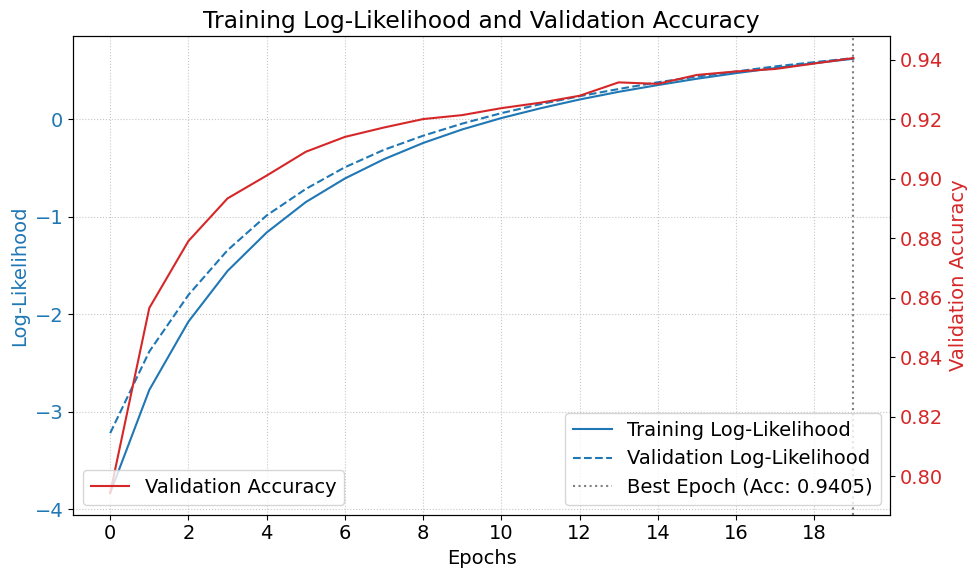

In [18]:
# Plot Log-Likelihood and Validation Accuracy
fig, ax1 = plt.subplots(figsize=(10, 6))
plt.rcParams.update({'font.size': 14})

color = 'tab:blue'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Log-Likelihood', color=color)
ax1.plot(log_ll_train, label='Training Log-Likelihood', color=color, linestyle='-')
ax1.plot(log_ll_val, label='Validation Log-Likelihood', color=color, linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='lower right')
ax1.grid(True, linestyle=':', alpha=0.7)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Validation Accuracy', color=color)
ax2.plot(val_accuracy_hist, label='Validation Accuracy', color=color, linestyle='-')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='lower left')

# Vertical line for best epoch based on accuracy
ax1.axvline(best_epoch_idx, color='grey', linestyle=':', label=f'Best Epoch (Acc: {best_val_accuracy:.4f})')
ax1.legend(loc='lower right') # Combine legends slightly better

plt.title('Training Log-Likelihood and Validation Accuracy')
plt.xticks(np.arange(0, n_epochs, 2)) # Adjust ticks if needed
fig.tight_layout() # otherwise the right y-label is slightly clipped
plt.show()


## Évaluation sur l'ensemble de test


In [16]:
# Evaluate the best model on the test data (using batches)
all_test_preds = []
all_test_true = []
test_log_likelihood = 0
n_samples_test = x_test_batch.shape[1]

for i in range(0, n_samples_test, batch_size):
    end_idx = min(i + batch_size, n_samples_test)
    x_test_batch_i = x_test_batch[:, i:end_idx]
    y_test_batch_i = y_test_batch[:, i:end_idx] # Ground truth one-hot for likelihood

    if x_test_batch_i.ndim == 1:
        x_test_batch_i = x_test_batch_i.reshape(n_features, -1)
    if y_test_batch_i.ndim == 1:
         y_test_batch_i = y_test_batch_i.reshape(n_classes, -1)

    # Forward pass using the best parameters found during validation
    Z_out_test, _ = model_forward(x_test_batch_i, best_params, layer_dims)
    Y_test = obs_model(Z_out_test, var_v) # (mu_y, var_y) shapes (n_classes, B)

    # Calculate log likelihood for the test batch
    batch_test_log_likelihood = log_likelihood(Y_test, y_test_batch_i)
    test_log_likelihood += batch_test_log_likelihood

    # Get predictions (class index) from logits (mu_y)
    mu_y_test, _ = Y_test
    batch_preds = np.argmax(mu_y_test, axis=0) # Predicted class index
    batch_true = np.argmax(y_test_batch_i, axis=0) # True class index

    all_test_preds.extend(batch_preds)
    all_test_true.extend(batch_true)

# Calculate overall test accuracy
test_accuracy = accuracy_score(all_test_true, all_test_preds)
avg_test_log_ll = test_log_likelihood / n_samples_test

print(f"\n--- Test Set Evaluation ---")
print(f"Average Log-Likelihood on Test Set: {avg_test_log_ll:.4f}")
print(f"Accuracy on Test Set: {test_accuracy:.4f} ({int(test_accuracy * n_samples_test)} / {n_samples_test})")


--- Test Set Evaluation ---
Average Log-Likelihood on Test Set: 0.6374
Accuracy on Test Set: 0.9410 (9410 / 10000)


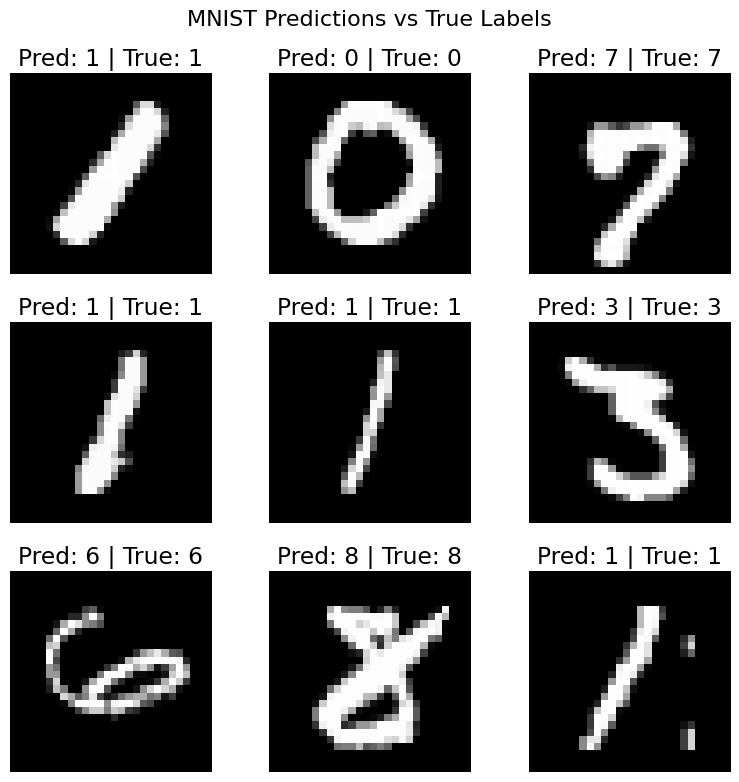

In [19]:
# Pick 9 random indices from test set
sample_indices = np.random.choice(x_test_batch.shape[1], size=9, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
fig.suptitle('MNIST Predictions vs True Labels', fontsize=16)

for i, idx in enumerate(sample_indices):
    ax = axes[i // 3, i % 3]
    
    img = x_test_batch[:, idx].reshape(28, 28)
    pred_label = all_test_preds[idx]
    true_label = all_test_true[idx]
    
    # Highlight incorrect predictions in red
    if pred_label != true_label:
        title_color = 'red'
    else:
        title_color = 'black'
        
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Pred: {pred_label} | True: {true_label}', color=title_color)
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()